# 프로젝트: SentencePiece 사용하기
## SentencePiece
- 논문:  https://arxiv.org/pdf/1808.06226.pdf

내부 단어(subword) 분리를 위한 유용한 패키지. BPE알고리즘과 Unigram Langauge Model Tokenizer를 구현한 SentencePiece가 있다. SentencePiece는 사전 토큰화 없이 전처리를 하지 않은 데이터에 바로 단어 분리 토큰화를 사용하므로 언어에 종속되지 않는다. 

n-gram을 기반으로 token의 빈도가 가장 빈번하게 하는 단위로 토큰화를 하는데, vocab_size가 크면 단어 단위로 토큰화하고, vocab_size가 작으면 음절 단위로 토큰화하는 경향이 있다. 

### Unigram Language Model Tokenizer
- 논문 : https://arxiv.org/pdf/1804.10959.pdf

유니그램 언어 모델 토크나이저는 각각의 subword에 대한 손실을 계산한다. subword에 대한 손실은 해당 subword가 단어 집합에서 제거되었을 때, 코퍼스의 가능도(likelihood)가 감소하는 정도이다. 이렇게 측정된 subword는 손실이 큰 순서대로 정렬하여 손실이 큰 10~20%의 토큰을 제거한다. 원하는 단어 집합에 크기가 될 때까지 손실이 큰 토큰을 제거한다.
 
### BPE 알고리즘
- 논문 : https://arxiv.org/pdf/1508.07909.pdf

훈련 데이터에 있는 단어를 모든 글자 또는 유니코드 단위로 단어집합을 만들고 가장 많이 등장하는 유니그램을 하나의 유니그램으로 통합한다. BPE 알고리즘은 OOV문제를 해결할 수 있다. 동작 과정은 아래의 그림과 같다. 

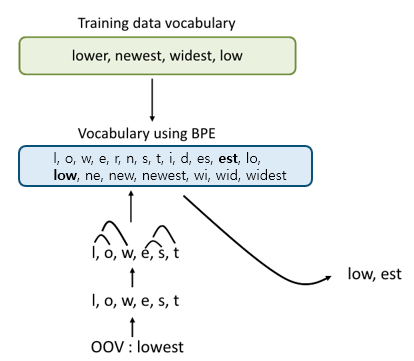


## Step 1. SentencePiece 설치하기
[SentencePiece](https://github.com/google/sentencepiece)는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer / Detokenizer로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것이다. 

SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있어서 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하고 있다. 

```python
# 설치
$ pip install sentencepiece
```

## Step 2. SentencePiece 모델 학습
토큰화를 하기 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 한다.

In [1]:
# import 패키지
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import sentencepiece as spm
from tensorflow.keras.models import load_model
import urllib.request
import csv

In [118]:
import os

path_to_file = os.getenv("HOME")+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

cleaned_corpus = list(set(raw))

max_len = 150
min_len = 10
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

In [119]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

# tokenizer 학습
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44 416170  4월 20 00:01 korean_spm.model
-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44 187371  4월 20 00:01 korean_spm.vocab


1. 모델의 하이퍼파라미터 설정         
모델의 하이퍼파라미터를 string으로 설정한다. 

```python
# 예
templates= '--input={} \
--pad_id={} \   
--bos_id={} \   # <start> token
--eos_id={} \   # <end> token
--unk_id={} \   # <unknown> token
--model_prefix={} \   # 저장될 tokenizer 모델에 붙는 이름
--vocab_size={} \   
--character_coverage={} \  # 얼마나 자소단위 셋을 줄여 단어단위 셋으로 coverage시킬것인가
--model_type={}'    # Choose from unigram(default), bpe, char, or word

cmd = templates.format(train_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                prefix,
                vocab_size,
                character_coverage,
                model_type)
```

2. Toeknizer 학습         
학습이 잘 되면 True 반환, 이 부분이 완료되면 prefix를 가진 두 파일이 생성됨. 
```korean_spm.model```: 실제로 사용되는 tokenizer 모델          
```korean_spm.vocab```: 참조하는 단어 집합

- 학습된 SentencePiece 모델의 활용 방법

In [120]:
# 모델 불러오기
s = spm.SentencePieceProcessor()
s.Load("korean_spm.model")

# 토큰화 수행
# SentencePiece를 활용한 sentence -> encoding(ids로 토큰화)
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces(string으로 토큰화)
tokens = s.SampleEncodeAsPieces('아버지가방에들어가신다.', 1, 0.0)  # 노드 버전
print(tokens)

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))
print(s.DecodePieces(tokens))

[1160, 11, 407, 7, 3375, 11, 292, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
아버지가방에들어가신다.


참고: 

- Pieces sampling
  - deterministic-based: 1
  - probability-based: -1
    - alpha =1.0: more likely sampling
    - alpha =0.0: uniformly sampling
    
    
- SentencePiece Tokenizer는 n-gram의 가장 빈도가 높은 Top 1의 기준만 사용한다.
그래서 이 패키지 안에는 확률적으로 다양한 tokenized된 example들을 샘플링 할 수 있는데 사용방법은 아래와 같다.

In [121]:
for i in s.NBestEncodeAsPieces("아버지방에들어가신다", 5):
    print(i)

['▁아버지', '방', '에', '들어', '가', '신', '다']
['▁아버지', '방', '에', '들', '어', '가', '신', '다']
['▁', '아버지', '방', '에', '들어', '가', '신', '다']
['▁아', '버', '지방', '에', '들어', '가', '신', '다']
['▁', '아버지', '방', '에', '들', '어', '가', '신', '다']


In [122]:
# korean_spm.vocab

with open('./korean_spm.vocab', encoding='utf-8') as f:
    Vo = [doc.strip().split("\t") for doc in f]

word2idx = {w[0]: i for i, w in enumerate(Vo)}

In [123]:
# 단어 집합

import pandas as pd
import csv
vocab_list = pd.read_csv('korean_spm.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,.,-3.37563
4,▁,-3.59722
5,을,-3.82401
6,의,-3.91124
7,에,-4.27135
8,를,-4.28187
9,는,-4.33737


In [124]:
len(vocab_list)

10000

## Step 3. Tokenizer 함수 작성
- 이전의 ```tokenize()``` 함수

```python
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
```

훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의한다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어려우므로 아래 조건을 만족하는 함수를 정의하도록 하습니다.

>1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.       
>2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.          
>3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [125]:
import tensorflow as tf
def sp_tokenize(s, corpus):
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open("./korean_spm.vocab", "r") as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({idx:word})
        index_word.update({word:idx})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="pre")
    
    return tensor, word_index, index_word

In [126]:
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)

print(tensor)

[[   0    0    0    0    0    0    0 1773 5634    5    4 9975 2674    3]
 [  98 1518   94    4    0  562   11    4   14    0 1822    3    3    3]]


In [127]:
# 단어사전
#print(word_index)

## Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

아마 여러분들은 [네이버 영화리뷰 감정분석 태스크](https://github.com/e9t/nsmc/)를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

- 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기
- Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.
- 머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

### 데이터 준비와 확인
label: 0은 부정, 1은 긍정

#### 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기
#### 1. unigram 알고리즘

In [128]:
import os

path_to_file = os.getenv("HOME")+'/aiffel/sentiment_classification/ratings.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

cleaned_corpus = list(set(raw))

max_len = 150
min_len = 10
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

In [129]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sentiment_classification/ratings.txt'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

# tokenizer 학습
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_spm*

-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44 406332  4월 20 00:02 naver_spm.model
-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44 177638  4월 20 00:02 naver_spm.vocab


In [130]:
sn = spm.SentencePieceProcessor()
sn.Load("naver_spm.model")

True

위의 SentencePiece 모델은 unigram으로 구성되어 있고 단어 사전의 크기는 5000이다. 사전에서 학습된 subwords를 확인해본다. 

In [131]:
vocab_list = pd.read_csv('naver_spm.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁1,-3.54063
4,▁,-3.55452
5,▁0,-3.68102
6,.,-3.68983
7,..,-4.57486
8,▁9,-4.62630
9,이,-4.73088


In [132]:
len(vocab_list)

10000

제대로 만들어졌는지 실험해 보자.

In [133]:
# 토큰화 수행
# SentencePiece를 활용한 sentence -> encoding(ids로 토큰화)
tokensIDs = sn.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces(string으로 토큰화)
tokens = sn.SampleEncodeAsPieces('아버지가방에들어가신다.', 1, 0.0)  # 노드 버전

print(tokens)

# SentencePiece를 활용한 encoding -> sentence 복원
print(sn.DecodeIds(tokensIDs))
print(sn.DecodePieces(tokens))

[1754, 15, 426, 20, 1554, 15, 154, 24, 6]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
아버지가방에들어가신다.


#### 2. bpe 알고리즘

In [134]:
import os

path_to_file = os.getenv("HOME")+'/aiffel/sentiment_classification/ratings.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

cleaned_corpus = list(set(raw))

max_len = 150
min_len = 10
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

In [135]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sentiment_classification/ratings.txt'


with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')
vocab_size = 10000
model_type = 'bpe'

# tokenizer 학습

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_bpe_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size, model_type)    
)

!ls -l naver_bpe_spm*

-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44 401908  4월 20 00:03 naver_bpe_spm.model
-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44 143138  4월 20 00:03 naver_bpe_spm.vocab


In [136]:
sp = spm.SentencePieceProcessor()
sp.Load("naver_bpe_spm.model")

True

In [137]:
vocab_list = pd.read_csv('naver_bpe_spm.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,▁1,0
4,▁0,-1
5,..,-2
6,영화,-3
7,▁영화,-4
8,▁이,-5
9,▁9,-6


In [138]:
len(vocab_list)

10000

제대로 만들어졌는지 실험해 보자.

In [139]:
# 토큰화 수행
# SentencePiece를 활용한 sentence -> encoding(ids로 토큰화)
tokensIDs = sp.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces(string으로 토큰화)
tokens = sp.SampleEncodeAsPieces('아버지가방에들어가신다.', 1, 0.0)  # 노드 버전

print(tokens)

# SentencePiece를 활용한 encoding -> sentence 복원
print(sp.DecodeIds(tokensIDs))
print(sp.DecodePieces(tokens))

[5912, 1011, 8641, 8389, 1647, 8385, 8484, 8374, 8367]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
아버지가방에들어가신다.


####  학습된 모델로 sp_tokenize() 메소드 구현하기
1. unigram 알고리즘

In [140]:
import tensorflow as tf
def spn_tokenize(sn, corpus):
    tensor = []
    
    for sen in corpus:
        tensor.append(sn.EncodeAsIds(sen))
        
    with open("./naver_spm.vocab", "r") as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({idx:word})
        index_word.update({word:idx})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="pre")
    
    return tensor, word_index, index_word

이번에도 확인해 보자.

In [141]:
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = spn_tokenize(sn, my_corpus)

print(tensor)

[[   0    0    0  511 3902   19 1616 3682    6]
 [2320 3395  283  642   15  247 9943  719   11]]


2. bpe 알고리즘

In [142]:
import tensorflow as tf
def spb_tokenize(sp, corpus):
    tensor = []
    
    for sen in corpus:
        tensor.append(sp.EncodeAsIds(sen))
        
    with open("./naver_bpe_spm.vocab", "r") as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({idx:word})
        index_word.update({word:idx})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="pre")
    
    return tensor, word_index, index_word

이번에도 확인해 보자.

In [143]:
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = spb_tokenize(sp, my_corpus)

print(tensor)

[[   0    0    0  839 3466 8403  690  966 8367]
 [1991 3045  449  119 8385  202 9736   21   12]]


#### 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기
SentencePiece로 토큰화 함수를 만들었으니 토큰화, 불용어 제거, 5) 사전 word_to_index 구성 6) 텍스트 스트링을 사전 인덱스 스트링으로 변환 7) X_train, y_train, X_test, y_test, word_to_index 리턴 을 해야 한다.

In [181]:
# 데이터를 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')
print(len(train_data), len(test_data))

# train_data의 첫 5행 확인
train_data.head()


150000 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [182]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


##### 데이터 전처리

In [183]:
# 중복데이터, 결측치 제거
train_data.drop_duplicates(subset=['document'], inplace=True)   # 데이터의 중복 제거   
train_data = train_data.dropna(how = 'any')                     # NaN 결측치 제거
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

In [184]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [185]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [186]:
print(len(train_data), len(test_data))

146182 49157


In [187]:
# 정규 표현식 사용
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


정규 표현식을 사용하면 한국어가 아닌 리뷰의 경우는 빈 값이 되었을 것이다. 그래서 공백만 있거나 빈 값을 가진 행을 Null값으로 변경하고 확인한다. 혹시 결측치가 생겼다면 제거한다.

In [188]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [189]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


테스트 데이터에 대해서도 동일한 과정을 수행해준다. 

In [190]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


전처리 후 테스트용 샘플의 개수 : 48852


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [154]:
# 토큰화
train_tensor, train_word_index, train_index_word = spn_tokenize(sn, train_data['document'])
test_tensor, test_word_index, test_index_word = spn_tokenize(sn, test_data['document'])

In [155]:
print(train_tensor)

[[   0    0    0 ... 3106   77 2638]
 [   0    0    0 ... 9027  775  458]
 [   0    0    0 ... 3094 2582  332]
 ...
 [   0    0    0 ...   23 9380   24]
 [   0    0    0 ...  327  206  148]
 [   0    0    0 ...  409 6965   10]]


In [156]:
print(test_tensor)

[[   0    0    0 ...    0 2765  289]
 [   0    0    0 ...  786 9335 6770]
 [   0    0    0 ...  125 2665 5800]
 ...
 [   0    0    0 ... 6842   94 3800]
 [   0    0    0 ...  354  793   57]
 [   0    0    0 ...   17  199 5000]]


In [157]:
print(len(train_tensor), len(test_tensor))

145393 48852


SentencePiece모델을 사용하면 단어 시퀀스가 자동으로 정수 인코딩이 되므로 불용어 제거를 할 수 없었다. 

train_data와 test_data에서 y_train, y_test를 별도로 저장한다. 

In [158]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [159]:
print(len(y_train), len(y_test))

145393 48852


train_tensor와 test_tensor의 길이가 동일하다. 

In [160]:
max(len(l) for l in train_tensor), min(len(l) for l in train_tensor)

(132, 132)

In [161]:
max(len(l) for l in test_tensor), min(len(l) for l in test_tensor)

(107, 107)

##### 네이버 영화 리뷰 감성 분류하기 

##### 모델 설계
LSTM 레이어를 사용한 RNN 모델을 사용하여 모델 설계를 한다.

In [162]:
vocab_size = vocab_size    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNNmodel 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였다. LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [163]:
es = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=3)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(train_tensor,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,  
                    verbose=1,
                    callbacks=[es,mc])

Epoch 1/20
909/909 [==============================] - 14s 14ms/step - loss: 0.4950 - accuracy: 0.7635 - val_loss: 0.3467 - val_accuracy: 0.8488

Epoch 00001: val_accuracy improved from -inf to 0.84879, saving model to best_model.h5
Epoch 2/20
909/909 [==============================] - 13s 14ms/step - loss: 0.2985 - accuracy: 0.8726 - val_loss: 0.3360 - val_accuracy: 0.8533

Epoch 00002: val_accuracy improved from 0.84879 to 0.85333, saving model to best_model.h5
Epoch 3/20
909/909 [==============================] - 13s 14ms/step - loss: 0.2572 - accuracy: 0.8889 - val_loss: 0.3502 - val_accuracy: 0.8529

Epoch 00003: val_accuracy did not improve from 0.85333
Epoch 4/20
909/909 [==============================] - 13s 14ms/step - loss: 0.2234 - accuracy: 0.9043 - val_loss: 0.3697 - val_accuracy: 0.8508

Epoch 00004: val_accuracy did not improve from 0.85333
Epoch 5/20
909/909 [==============================] - 13s 14ms/step - loss: 0.1905 - accuracy: 0.9201 - val_loss: 0.3910 - val_accura

In [164]:
# 평가
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(test_tensor,  y_test, verbose=2)

print(results)

1527/1527 - 3s - loss: 0.3419 - accuracy: 0.8504
[0.34188151359558105, 0.8503848314285278]


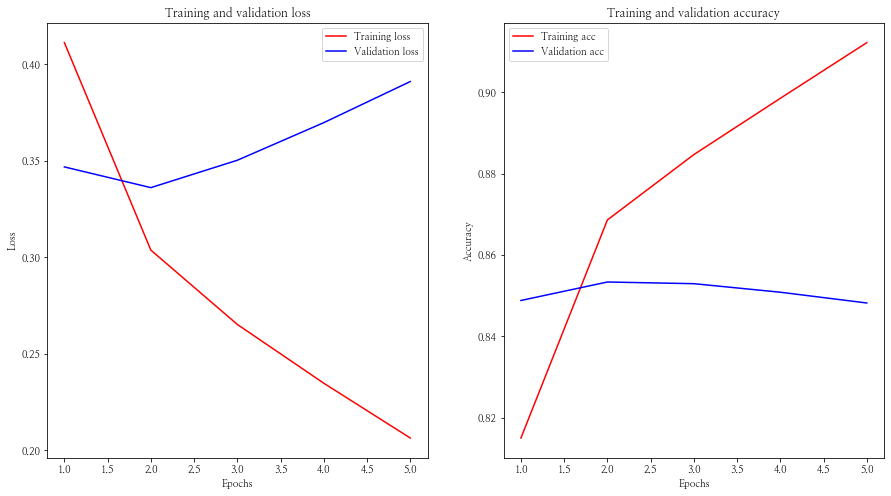

In [165]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'r', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 다양한 실험
동일한 조건에서 실험하기 위해서 SentencePiece 모델의 vacab_size, 데이터 전처리, 모델을 모두 같게 하였다. 

####  1. 노드에 나온 코퍼스(korean-parallel-corpora)로 만든 SentencePiece 모델 적용해 보기

In [176]:
# 토큰화
train_tensor, train_word_index, train_index_word = sp_tokenize(s, train_data['document'])
test_tensor, test_word_index, test_index_word = sp_tokenize(s, test_data['document'])

In [177]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

##### 모델 설계
LSTM 레이어를 사용한 RNN 모델을 사용하여 모델 설계를 한다.

In [178]:
vocab_size = vocab_size   # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNNmodel 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였다. LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [179]:
es = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=3)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(train_tensor,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es,mc])

Epoch 1/20
909/909 [==============================] - 14s 15ms/step - loss: 0.4982 - accuracy: 0.7519 - val_loss: 0.3903 - val_accuracy: 0.8231

Epoch 00001: val_accuracy improved from -inf to 0.82307, saving model to best_model.h5
Epoch 2/20
909/909 [==============================] - 13s 14ms/step - loss: 0.3647 - accuracy: 0.8379 - val_loss: 0.3840 - val_accuracy: 0.8248

Epoch 00002: val_accuracy improved from 0.82307 to 0.82475, saving model to best_model.h5
Epoch 3/20
909/909 [==============================] - 13s 14ms/step - loss: 0.3301 - accuracy: 0.8557 - val_loss: 0.3690 - val_accuracy: 0.8353

Epoch 00003: val_accuracy improved from 0.82475 to 0.83528, saving model to best_model.h5
Epoch 4/20
909/909 [==============================] - 13s 14ms/step - loss: 0.3019 - accuracy: 0.8703 - val_loss: 0.3688 - val_accuracy: 0.8372

Epoch 00004: val_accuracy improved from 0.83528 to 0.83720, saving model to best_model.h5
Epoch 5/20
909/909 [==============================] - 13s 14ms/

In [180]:
# 평가
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(test_tensor,  y_test, verbose=2)

print(results)

1527/1527 - 4s - loss: 0.3770 - accuracy: 0.8334
[0.37697136402130127, 0.8333742618560791]


#### 2. KoNLPy 형태소 분석기(Mecab)를 사용한 모델과 성능 비교하기

In [109]:
# 토큰화

from konlpy.tag import Mecab
tokenizer = Mecab()

def load_data(train_data, test_data, num_words=10000):    # 호출시 단어사전에 등재할 단어의 개수

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)                          # 한국어 토크나이저로 토큰화
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)                          # 한국어 토크나이저로 토큰화
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)           # 특수문자 4개 제외한 단어 수 세기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}              # 사전(word_to_index) 구성

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [110]:
# 패딩

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre')

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre')
print(X_train.shape)
print(X_test.shape)

(145393, 95)
(48852, 93)


In [111]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [112]:
print(len(y_train))

145393


##### 모델 설계
LSTM 레이어를 사용한 RNN 모델을 사용하여 모델 설계를 한다.

In [115]:
vocab_size = 10000    # 어휘 사전의 크기(5000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNNmodel 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였다. LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [116]:
es = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=3)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es,mc])

Epoch 1/20
909/909 [==============================] - 12s 12ms/step - loss: 0.4921 - accuracy: 0.7654 - val_loss: 0.3548 - val_accuracy: 0.8434

Epoch 00001: val_accuracy improved from -inf to 0.84336, saving model to best_model.h5
Epoch 2/20
909/909 [==============================] - 11s 12ms/step - loss: 0.3158 - accuracy: 0.8644 - val_loss: 0.3421 - val_accuracy: 0.8488

Epoch 00002: val_accuracy improved from 0.84336 to 0.84879, saving model to best_model.h5
Epoch 3/20
909/909 [==============================] - 11s 12ms/step - loss: 0.2791 - accuracy: 0.8807 - val_loss: 0.3473 - val_accuracy: 0.8515

Epoch 00003: val_accuracy improved from 0.84879 to 0.85147, saving model to best_model.h5
Epoch 4/20
909/909 [==============================] - 11s 12ms/step - loss: 0.2421 - accuracy: 0.8982 - val_loss: 0.3527 - val_accuracy: 0.8518

Epoch 00004: val_accuracy improved from 0.85147 to 0.85182, saving model to best_model.h5
Epoch 5/20
909/909 [==============================] - 11s 12ms/

In [117]:
# 평가
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1527/1527 - 3s - loss: 0.3573 - accuracy: 0.8509
[0.35733962059020996, 0.8508556485176086]


#### 3. SentencePiece 모델의 bpe 알고리즘 사용


In [94]:
# 토큰화
train_tensor, train_word_index, train_index_word = spb_tokenize(sp, train_data['document'])
test_tensor, test_word_index, test_index_word = spb_tokenize(sp, test_data['document'])

In [95]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

##### 모델 설계
LSTM 레이어를 사용한 RNN 모델을 사용하여 모델 설계를 한다.

In [96]:
vocab_size = vocab_size   # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNNmodel 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였다. LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 503,569
Trainable params: 503,569
Non-trainable params: 0
_________________________________________________________________


In [97]:
es = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=3)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(train_tensor,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es,mc])

Epoch 1/20
909/909 [==============================] - 12s 12ms/step - loss: 0.5023 - accuracy: 0.7585 - val_loss: 0.3714 - val_accuracy: 0.8348

Epoch 00001: val_accuracy improved from -inf to 0.83476, saving model to best_model.h5
Epoch 2/20
909/909 [==============================] - 10s 11ms/step - loss: 0.3426 - accuracy: 0.8498 - val_loss: 0.3517 - val_accuracy: 0.8428

Epoch 00002: val_accuracy improved from 0.83476 to 0.84277, saving model to best_model.h5
Epoch 3/20
909/909 [==============================] - 10s 11ms/step - loss: 0.3097 - accuracy: 0.8670 - val_loss: 0.3502 - val_accuracy: 0.8466

Epoch 00003: val_accuracy improved from 0.84277 to 0.84659, saving model to best_model.h5
Epoch 4/20
909/909 [==============================] - 10s 11ms/step - loss: 0.2866 - accuracy: 0.8787 - val_loss: 0.3583 - val_accuracy: 0.8443

Epoch 00004: val_accuracy did not improve from 0.84659
Epoch 5/20
909/909 [==============================] - 10s 11ms/step - loss: 0.2644 - accuracy: 0.8

In [98]:
# 평가
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(test_tensor,  y_test, verbose=2)

print(results)

1527/1527 - 4s - loss: 0.3580 - accuracy: 0.8428
[0.357950896024704, 0.842769980430603]


#### 5. sentencepiece 모델 vocab_list = 10000, bpe 알고리즘 

In [191]:
# 토큰화
train_tensor, train_word_index, train_index_word = spb_tokenize(sp, train_data['document'])
test_tensor, test_word_index, test_index_word = spb_tokenize(sp, test_data['document'])

In [192]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [193]:
vocab_size = vocab_size    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNNmodel 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였다. LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [194]:
es = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=3)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(train_tensor,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,  
                    verbose=1,
                    callbacks=[es,mc])

Epoch 1/20
909/909 [==============================] - 13s 13ms/step - loss: 0.5021 - accuracy: 0.7505 - val_loss: 0.3503 - val_accuracy: 0.8466

Epoch 00001: val_accuracy improved from -inf to 0.84659, saving model to best_model.h5
Epoch 2/20
909/909 [==============================] - 12s 13ms/step - loss: 0.3136 - accuracy: 0.8680 - val_loss: 0.3437 - val_accuracy: 0.8489

Epoch 00002: val_accuracy improved from 0.84659 to 0.84889, saving model to best_model.h5
Epoch 3/20
909/909 [==============================] - 12s 13ms/step - loss: 0.2671 - accuracy: 0.8891 - val_loss: 0.3444 - val_accuracy: 0.8524

Epoch 00003: val_accuracy improved from 0.84889 to 0.85237, saving model to best_model.h5
Epoch 4/20
909/909 [==============================] - 12s 13ms/step - loss: 0.2338 - accuracy: 0.9034 - val_loss: 0.3570 - val_accuracy: 0.8479

Epoch 00004: val_accuracy did not improve from 0.85237
Epoch 5/20
909/909 [==============================] - 12s 13ms/step - loss: 0.2070 - accuracy: 0.9

In [195]:
# 평가
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(test_tensor,  y_test, verbose=2)

print(results)

1527/1527 - 4s - loss: 0.3520 - accuracy: 0.8473
[0.35199958086013794, 0.8473348021507263]


## 실험결과

실험을 위해 5번을 제외하고 다음의 조건을 동일하게 맞춰주었다. 
- SentencePiece 모델의 vocab_size=10000, 
- 동일한 전처리: 결측치제거, 중복데이터 제거, 정규표현식 사용
- 동일한 모델(LSTM, LSTM state 벡터의 차원수는 8)

1. korean-parallel-corpora로 만든 SentencePiece 모델             
- accuracy: 0.8334

2. 네이버 영화리뷰 감정분석 코퍼스를 이용한 SentencePiece 모델 - unigram 알고리즘    
- accuracy: 0.8504

3. 네이버 영화리뷰 감정분석 코퍼스를 이용한 SentencePiece 모델 - bpe 알고리즘       
- accuracy: 0.8473

4. KoNLPy 형태소 분석기(Mecab)    
- accuracy: 0.8509

위의 4가지 방법으로 실험을 하였을 때, KoNLPy이 가장 좋은 성능을 보였다. 

네이버 영화리뷰 감정분석 코퍼스에 SentencePiece를 적용시킨 모델 중 unigram 알고리즘이 2번째로 좋은 성능을 보였다. bpe는 3번째로, unigram 알고리즘보다 조금 낮은 성능을 보였다. 이 결과가 일반적인가 싶어 찾아보았지만 답을 찾을 수 없었다. 

korean-parallel-corpora로 만든 SentencePiece 모델보다 네이버 영화리뷰 감정분석 코퍼스 SentencePiece 모델이 더 좋은 성능을 보이는 것은 학습한 모델의 코퍼스가 태스크에 사용된 코퍼스와 동일하기 때문인 것 같다. 

- vocab_list 크기 조절 (vocab_list=5000)
5. 네이버 영화리뷰 감정분석 코퍼스를 이용한 SentencePiece 모델 - unigram 알고리즘
- accuracy: 0.8420

6. 네이버 영화리뷰 감정분석 코퍼스를 이용한 SentencePiece 모델 - bpe 알고리즘
- accuracy: 0.8428

sentencepiece 모델의 vocab_list의 수를 증가시켰을 때 모델의 성능이 더 높아짐을 알 수 있었다. 

그러나 위에서 했던 모든 실험 결과는 거의 비슷한 성능을 보인다. 

## 루브릭
|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|Y     |
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|Y  |
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.| Y    |

## 후기
### 이번 프로젝트에서 어려웠던 점
- 패딩을 post로 했더니 정확도가 50% 정도로 나와서 한참을 고민했다. 그러다 RNN은 이전에 들어온 정보를 점차 소실한다는 것이 기억이 나서 패딩을 pre로 한 후에야 정확도가 올랐다. 
- KoNLPy 형태소 분석기(Mecab)를 사용하는 부분에서 이전에 사용했던 tokenize() 함수를 사용하려고 하였으나 단어 집합의 크기가 커서인지 작꾸만 에러 메시지가 나왔다. 문제를 해결하려고 다양한 시도를 해보았으나 결국 tokenize()함수를 사용하지 못하고 기존 프로젝트에 사용했던 함수를 사용하였다. 

### 프로젝트를 진행하면서 알게된 점
- RNN에서의 pre와 post의 차이점(이전에 했던 네이버 영화 리뷰 감성분석에서는 padding을 pre와 post로 했을 때 별 차이가 나지 않았었다.)을 다시 깨달았다.
- SentencePiece모델, Unigram 알고리즘과 BPE 알고리즘의 개념

### 프로젝트를 진행하면서 아직 모호한 점
- SentencePiece모델을 쓸 때 다른 텍스트 전처리는 어떻게 해야 하는지 모르겠다. 텍스트 전처리 순서를 찾아보니 토큰화를 하고 불용어 처리를 하기에 SentencePiece모델을 사용하고 나서 불용어 처리를 해보았더니 잘 되지 않았다(시간이 너무 오래 걸려서 중간에 그만 둠).    


### 자기 다짐
SentencePiece 모델의 개념을 공부했지만 모델을 실제 태스크에 적용하는 것이 아직 어렵다. SentencePiece 모델을 사용할 때 불용어 처리는 어떻게 해야 하는 것인지, 문장의 길이는 어떻게 적용시켜야 하는 것인지 등 모르는 부분이 많다. KoNPLy 형태소 분석기를 사용하고 나서는 최대 문장의 길이를 정하고 패딩을 해주었지만 이번 노드에서는 SentencePiece 모델을 적용하고 바로 패딩까지 해주었다. 이 경우 긴 문장은 어떻게 처리가 되는 것인지 궁금하다. 아직 SentencePiece 모델을 제대로 알지 못해서 그런 것 같다. 

또한 KoNLPy 형태소 분석기(Mecab)를 사용하는 부분에서 tokenize() 함수를 사용하지 못한 것도 토큰화에 대해 제대로 알지 못해서인 것 같아 아쉬움이 매우 크다. 코드를 보고 따라하거나 조금 수정하는 것은 할 수 있지만 새롭게 적용하는 방법을 아직 잘 모르겠다.Going Deeper의 첫 프로젝트였지만 제대로 소화하지 못한 것 같아 아쉽다.

- 참고문헌       
[02) 센텐스피스(SentencePiece)](https://wikidocs.net/86657)    
https://donghwa-kim.github.io/SPM.html      
[6) 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)](https://wikidocs.net/44249)          
[01) 바이트 페어 인코딩(Byte Pair Encoding, BPE)](https://wikidocs.net/22592)         
[네이버 영화 리뷰 감성분석하기 - 프로젝트4](https://github.com/guide333/AD/blob/master/Exploration/%5BE-04%5DNaver_movie_review_sentiment_analysis_vec.ipynb)
